In [1]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ml_wireless_classification.base.SignalUtils import (
    compute_instantaneous_features,
    compute_modulation_index,
    compute_spectral_asymmetry,
    instantaneous_frequency_deviation,
    spectral_entropy,
    envelope_mean_variance,
    spectral_flatness,
    spectral_peaks_bandwidth,
    zero_crossing_rate,
    compute_fft_features,
    autocorrelation,
    is_digital_signal,
    compute_kurtosis,
    compute_skewness,
    compute_spectral_energy_concentration,
    compute_instantaneous_frequency_jitter,
    compute_spectral_kurtosis,
    compute_higher_order_cumulants,
    compute_crest_factor,
    compute_spectral_entropy,
    compute_energy_spread,
    compute_autocorrelation_decay,
    compute_rms_of_instantaneous_frequency,
    compute_entropy_of_instantaneous_frequency,
    compute_envelope_variance,
    compute_papr,
)
import pickle
import numpy as np
import torch
from scipy.signal import hilbert, welch
from scipy.fft import fft
from scipy.stats import kurtosis, skew
from scipy.ndimage import gaussian_filter1d
import pywt
from scipy.signal import hilbert, find_peaks, stft
from scipy.ndimage import gaussian_filter1d
from ml_wireless_classification.base.ANR import AdaptiveNoiseReduction
from scipy.signal import butter, filtfilt


# Kernel application function
def apply_kernel(signal, kernel="linear", band="full", adaptive=False):
    """Applies a specified kernel to the signal."""
    if kernel == "cubic":
        return signal**3
    elif kernel == "quartic":
        return signal**4
    elif kernel == "polynomial":
        poly = np.poly1d([1, 0, -1])  # Example polynomial
        return poly(signal)
    elif kernel == "gaussian":
        sigma = (
            1 if not adaptive else max(0.1, min(2, np.std(signal) / np.mean(signal)))
        )
        return gaussian_filter1d(signal, sigma=sigma)
    else:
        return signal  # Linear (default) does nothing


def apply_bandpass_filter(signal, low_cut, high_cut, fs=1.0, order=4):
    """
    Apply a Butterworth bandpass filter to a signal.

    Parameters:
    - signal: array-like, the input signal
    - low_cut: float, the low cutoff frequency as a fraction of the Nyquist rate
    - high_cut: float, the high cutoff frequency as a fraction of the Nyquist rate
    - fs: float, the sampling frequency of the signal (default 1.0)
    - order: int, the order of the Butterworth filter (default 4)

    Returns:
    - filtered_signal: array-like, the bandpass-filtered signal
    """
    nyquist = 0.5 * fs
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(order, [low, high], btype="band")
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


# Kernelized Frequency Domain Features
def spectral_entropy(signal):
    psd = np.abs(fft(signal)) ** 2
    psd_norm = psd / np.sum(psd)
    return -np.sum(psd_norm * np.log(psd_norm + 1e-10))


def spectral_flatness(signal):
    psd = np.abs(fft(signal)) ** 2
    geometric_mean = np.exp(np.mean(np.log(psd + 1e-10)))
    arithmetic_mean = np.mean(psd)
    return geometric_mean / (arithmetic_mean + 1e-10)


def energy_concentration(signal, low_cut=0.1, high_cut=0.5):
    f, Pxx = welch(signal)
    band_mask = (f >= low_cut) & (f <= high_cut)
    return np.sum(Pxx[band_mask])


def bandwidth_concentration(signal):
    psd = np.abs(fft(signal)) ** 2
    smooth_psd = gaussian_filter1d(psd, sigma=1)
    return np.sum(smooth_psd)


def frequency_spread(signal):
    f, Pxx = welch(signal)
    mean_freq = np.sum(f * Pxx) / np.sum(Pxx)
    return np.log(np.sqrt(np.sum((f - mean_freq) ** 2 * Pxx) / np.sum(Pxx)))


# Wavelet-Based Multi-Scale Analysis
def wavelet_power_variance(signal, kernel="morlet"):
    coeffs = pywt.wavedec(signal, kernel, level=4)
    power_peaks = [np.max(np.abs(c) ** 2) for c in coeffs[1:]]
    return np.var(power_peaks)


def wavelet_entropy(signal, kernel="quadratic"):
    coeffs = pywt.wavedec(signal, "db1", level=4)
    entropy_sum = np.sum(
        [-np.sum(np.abs(c) * np.log(np.abs(c) + 1e-10)) for c in coeffs]
    )
    return np.power(entropy_sum, 2)  # Quadratic kernel


def wavelet_coefficient_mean(signal, freq_band="high", kernel="quartic"):
    coeffs = pywt.wavedec(signal, "db1", level=4)
    high_band = coeffs[-1]  # Assuming the highest band for simplicity
    return np.mean(high_band)


# Time-Domain Features with Higher-Order Kernels
def zero_crossing_rate(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings) / len(signal)


def modulation_index(signal):
    envelope = np.abs(hilbert(signal))
    return np.var(envelope) / np.mean(envelope)


def phase_change_rate(signal):
    phase_diff = np.diff(np.angle(signal))
    return np.var(phase_diff)


def frequency_asymmetry(signal):
    inst_freq = np.diff(np.unwrap(np.angle(hilbert(signal))))
    return np.mean(inst_freq**3)


def rms_signal_envelope(signal):
    envelope = np.abs(hilbert(signal))
    return np.sqrt(np.mean(envelope**2))


# Higher-Order Statistical Features
def fourth_order_amplitude_moment(signal):
    centered_signal = signal - np.mean(signal)
    return np.mean(centered_signal**4)


def skewness_of_phase_changes(signal):
    phase_diff = np.diff(np.angle(signal))
    return np.power(skew(phase_diff), 3)


def cumulant(signal, order=6):
    return np.mean(signal**order)


# Cross-Domain Features (Time-Frequency)
def frequency_variance(signal):
    inst_freq = np.diff(np.unwrap(np.angle(signal)))
    return np.var(inst_freq)


def spectral_modulation_bandwidth(signal):
    f, Pxx = welch(signal)
    return np.sqrt(np.mean(f**2 * Pxx) - np.mean(f * Pxx) ** 2)


# Phase and Instantaneous Amplitude-Related Features
def phase_modulation_skewness(signal):
    phase_mod = np.angle(signal)
    return np.power(skew(phase_mod), 4)


def amplitude_asymmetry(signal):
    envelope = np.abs(hilbert(signal))
    return skew(envelope)


def correlation(phase, envelope):
    return np.corrcoef(phase, envelope)[0, 1]


# Energy Spread in Time-Frequency
def energy_spread_time_frequency(signal):
    f, Pxx = welch(signal)
    return np.std(Pxx)


# Temporal peak density
def peak_density(signal):
    peaks = np.diff(np.sign(np.diff(signal))) < 0
    return np.sum(peaks) / len(signal)


# Autocorrelation Skewness
def autocorrelation_skewness(signal):
    autocorr = np.correlate(signal, signal, mode="full")
    return skew(autocorr)


# Interquartile Range (IQR) of Envelope Peaks
def interquartile_range(signal):
    envelope = np.abs(hilbert(signal))
    return np.percentile(envelope, 75) - np.percentile(envelope, 25)


# Interquartile range (IQR) of envelope peaks
def envelope_peaks(signal):
    envelope = np.abs(hilbert(signal))
    return envelope


# Correlation between phase and envelope
def phase_envelope(signal):
    return np.abs(hilbert(signal)), np.angle(signal)


# WBFM-Specific Feature Functions


def frequency_modulation_rate(signal):
    inst_phase = np.unwrap(np.angle(signal))
    inst_freq = np.diff(inst_phase)
    return np.mean(np.abs(np.diff(inst_freq)))


def instantaneous_frequency_deviation_std(signal):
    inst_phase = np.unwrap(np.angle(signal))
    inst_freq = np.diff(inst_phase)
    return np.std(inst_freq)


def high_frequency_power_ratio(signal, cutoff=0.5):
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    high_freq_power = np.sum(np.abs(fft_values[np.abs(freqs) > cutoff]) ** 2)
    total_power = np.sum(np.abs(fft_values) ** 2)
    return high_freq_power / total_power if total_power > 0 else 0


def spectral_concentration_center(signal, center_freq=0):
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    center_band = (freqs >= center_freq - 0.1) & (freqs <= center_freq + 0.1)
    center_energy = np.sum(np.abs(fft_values[center_band]) ** 2)
    total_energy = np.sum(np.abs(fft_values) ** 2)
    return center_energy / total_energy if total_energy > 0 else 0


def energy_spread_time_frequency(signal, fs=1.0):
    f, t, Zxx = stft(signal, fs=fs, nperseg=128)
    return np.std(np.abs(Zxx))


def zero_crossing_density_frequency(signal):
    fft_values = np.fft.fft(signal)
    return np.mean(np.diff(np.sign(np.real(fft_values))) != 0)


def frequency_spread_log_cubic(signal):
    f, Pxx = welch(signal)
    mean_freq = np.sum(f * Pxx) / np.sum(Pxx)
    spread = np.log(np.sqrt(np.sum((f - mean_freq) ** 2 * Pxx) / np.sum(Pxx)) + 1e-10)
    return spread**3  # Cubic kernel applied


def adaptive_gaussian_filtering(signal):
    psd = np.abs(np.fft.fft(signal)) ** 2
    sigma = max(0.1, min(2, np.std(psd) / np.mean(psd)))
    filtered_psd = gaussian_filter1d(psd, sigma=sigma)
    return np.sum(filtered_psd)


def wavelet_high_order_kernel(signal, kernel="cubic"):
    coeffs = pywt.wavedec(signal, "db4", level=4)
    if kernel == "cubic":
        return np.mean([np.power(np.abs(c), 3).mean() for c in coeffs[1:]])
    elif kernel == "quartic":
        return np.mean([np.power(np.abs(c), 4).mean() for c in coeffs[1:]])


def frequency_modulation_rate(signal, fs=1.0):
    inst_freq = np.diff(np.unwrap(np.angle(hilbert(signal))))
    return np.mean(np.abs(np.diff(inst_freq))) * fs


def high_frequency_power_ratio(signal, cutoff=0.5, fs=1.0):
    f, Pxx = welch(signal, fs=fs)
    high_freq_power = np.sum(Pxx[f > cutoff])
    total_power = np.sum(Pxx)
    return high_freq_power / total_power if total_power > 0 else 0


def zero_crossing_density_frequency(signal):
    fft_signal = np.fft.fft(signal)
    crossings = np.where(np.diff(np.sign(np.real(fft_signal))))[0]
    return len(crossings) / len(signal)


def zero_crossing_density_frequency(signal):
    fft_signal = np.fft.fft(signal)
    crossings = np.where(np.diff(np.sign(np.real(fft_signal))))[0]
    return len(crossings) / len(signal)


def spectral_concentration_center(signal, center_freq=0.5, bandwidth=0.1, fs=1.0):
    f, Pxx = welch(signal, fs=fs)
    center_band = (f > center_freq - bandwidth) & (f < center_freq + bandwidth)
    return np.sum(Pxx[center_band]) / np.sum(Pxx)


def inst_freq_deviation_std(signal):
    inst_freq = np.diff(np.unwrap(np.angle(hilbert(signal))))
    return np.std(inst_freq)


def rms_signal_envelope(signal):
    envelope = np.abs(hilbert(signal))
    return np.sqrt(np.mean(envelope**2))


def amplitude_asymmetry(signal):
    envelope = np.abs(hilbert(signal))
    return skew(envelope)


def spectral_modulation_bandwidth(signal, fs=1.0):
    f, Pxx = welch(signal, fs=fs)
    return np.sqrt(np.mean(f**2 * Pxx) - np.mean(f * Pxx) ** 2)


def wavelet_transform_cubic(signal, level=4):
    coeffs = pywt.wavedec(signal, "db1", level=level)
    return np.mean(np.array([np.mean(np.abs(c) ** 3) for c in coeffs]))


# Band-Pass Filtered RMS of Signal Envelope
def band_pass_filtered_rms(signal, low_cut=0.05, high_cut=0.3):
    filtered_signal = apply_bandpass_filter(signal, low_cut, high_cut)
    envelope = np.abs(hilbert(filtered_signal))
    return np.sqrt(np.mean(envelope**2))


# Time-Frequency Energy Concentration
def time_frequency_energy_concentration(signal, low_freq=0.05, high_freq=0.3):
    f, t, Sxx = stft(signal, nperseg=256)
    band_mask = (f >= low_freq) & (f <= high_freq)
    energy_concentration = np.sum(Sxx[band_mask, :]) / np.sum(Sxx)
    return energy_concentration


# Peak Density in Filtered Frequency Domain
def peak_density_frequency_domain(signal):
    fft_signal = np.abs(fft(signal))
    smooth_fft = gaussian_filter1d(fft_signal, sigma=3)
    peaks = find_peaks(smooth_fft, height=0.1 * np.max(smooth_fft))[0]
    return len(peaks) / len(smooth_fft)


# Normalized High-Frequency Power Ratio
def normalized_high_freq_power_ratio(signal, high_cut=0.4):
    fft_signal = np.abs(fft(signal)) ** 2
    freqs = np.fft.fftfreq(len(signal))
    high_freq_power = np.sum(fft_signal[np.abs(freqs) > high_cut])
    total_power = np.sum(fft_signal)
    return high_freq_power / (total_power * (1 - high_cut))


# Frequency Domain Entropy with High-Frequency Emphasis
def high_freq_emphasis_entropy(signal, high_freq_cut=0.3):
    fft_signal = np.abs(fft(signal)) ** 2
    psd = fft_signal / np.sum(fft_signal)
    high_freqs = psd[len(psd) // 2 :]
    high_freq_entropy = -np.sum(high_freqs * np.log2(high_freqs + 1e-10))
    return high_freq_entropy


# Autocorrelation Energy Spread
def autocorrelation_energy_spread(signal):
    autocorr = np.correlate(signal, signal, mode="full")
    return np.var(autocorr)


# Instantaneous Frequency Standard Deviation
def instantaneous_frequency_std(signal):
    inst_freq = np.diff(np.angle(hilbert(signal)))
    return np.std(inst_freq)


# Temporal Energy Variance (Gaussian)
def temporal_energy_variance_gaussian(signal):
    envelope = np.abs(hilbert(signal))
    smooth_envelope = gaussian_filter1d(envelope, sigma=3)
    return np.var(smooth_envelope)


# Wavelet Energy Concentration (High Frequency)
def high_freq_wavelet_energy_concentration(signal):
    coeffs = pywt.wavedec(signal, "db1", level=4)
    high_freq_coeffs = coeffs[-1]  # Highest frequency coefficients
    return np.sum(np.abs(high_freq_coeffs) ** 2)


def frequency_spread_variability(signal, window_size=64):
    # Split signal into windows
    variances = []
    for i in range(0, len(signal) - window_size, window_size):
        window = signal[i : i + window_size]
        f, Pxx = welch(window)
        mean_freq = np.sum(f * Pxx) / np.sum(Pxx)
        variance = np.sqrt(np.sum((f - mean_freq) ** 2 * Pxx) / np.sum(Pxx))
        variances.append(variance)
    return np.var(variances)


def envelope_power_variability(signal, num_bands=4):
    envelope = np.abs(hilbert(signal))
    f, Pxx = welch(envelope)
    band_size = len(f) // num_bands
    band_variances = []
    for i in range(num_bands):
        band_power = np.sum(Pxx[i * band_size : (i + 1) * band_size])
        band_variances.append(band_power)
    return np.var(band_variances)


def instantaneous_frequency_rate_of_change(signal):
    inst_freq = np.diff(np.unwrap(np.angle(hilbert(signal))))
    rate_of_change = np.diff(inst_freq)
    return np.std(rate_of_change)


def fifth_order_cumulant(signal):
    centered_signal = signal - np.mean(signal)
    return np.mean(centered_signal**5)


def instantaneous_phase_deviation_rate(signal):
    phase = np.unwrap(np.angle(signal))
    phase_diff = np.diff(phase)
    return np.std(phase_diff)


def constellation_density(signal, num_bins=10):
    real_part = np.real(signal)
    imag_part = np.imag(signal)
    H, _, _ = np.histogram2d(real_part, imag_part, bins=num_bins)
    return np.var(H)  # Measure variance in density


# Spectral Density Features
def spectral_energy_density(signal):
    psd = np.abs(fft(signal)) ** 2
    return np.mean(psd)


def spectral_peak_ratio(signal):
    psd = np.abs(fft(signal)) ** 2
    max_peak = np.max(psd)
    mean_power = np.mean(psd)
    return max_peak / (mean_power + 1e-10)


# Frequency Deviation Features
def frequency_deviation_mean(signal):
    inst_freq = np.diff(np.unwrap(np.angle(signal)))
    return np.mean(np.abs(inst_freq))


def frequency_deviation_skewness(signal):
    inst_freq = np.diff(np.unwrap(np.angle(signal)))
    return skew(inst_freq)


# Phase and Amplitude Features
def phase_entropy(signal):
    phase = np.unwrap(np.angle(signal))
    hist, _ = np.histogram(phase, bins=64, density=True)
    hist = hist[hist > 0]  # Exclude zero entries for entropy calculation
    return -np.sum(hist * np.log2(hist))


def amplitude_spectral_flatness(signal):
    amplitude_spectrum = np.abs(fft(np.abs(signal)))
    geom_mean = np.exp(np.mean(np.log(amplitude_spectrum + 1e-10)))
    arith_mean = np.mean(amplitude_spectrum)
    return geom_mean / (arith_mean + 1e-10)


# Instantaneous Features
def instantaneous_amplitude_variance(signal):
    envelope = np.abs(hilbert(signal))
    return np.var(envelope)


def instantaneous_phase_kurtosis(signal):
    inst_phase = np.angle(signal)
    return kurtosis(inst_phase)


# Kernel-Enhanced Features
def high_order_wavelet_variance(signal):
    coeffs = pywt.wavedec(signal, "db2", level=4)
    high_order_coeff = coeffs[-1]
    return np.var(high_order_coeff**4)


def frequency_variability_gaussian(signal):
    freqs, Pxx = welch(signal)
    smooth_psd = gaussian_filter1d(Pxx, sigma=1)
    return np.var(smooth_psd)


def extract_comprehensive_features(complex_signal, real_signal):
    add_feature("Inst. Freq. Dev", instantaneous_frequency_deviation, complex_signal)
    add_feature(
        "Phase Variance",
        lambda x: np.var(compute_instantaneous_features(x)[1]),
        real_signal,
    )
    add_feature("Avg Symbol Power", lambda x: np.mean(np.abs(x) ** 2), complex_signal)
    add_feature(
        "PAPR",
        lambda x: np.max(np.abs(x) ** 2) / np.mean(np.abs(x) ** 2),
        complex_signal,
    )
    add_feature(
        "Kurtosis Magnitude", lambda x: compute_kurtosis(np.abs(x)), complex_signal
    )
    add_feature(
        "Skewness Magnitude", lambda x: compute_skewness(np.abs(x)), complex_signal
    )
    add_feature(
        "High-Frequency Spectral Entropy (Cubic)",
        lambda x: spectral_entropy(apply_kernel(x, kernel="cubic", band="high")),
        complex_signal,
    )
    add_feature(
        "Low-Frequency Spectral Flatness (Quartic)",
        lambda x: spectral_flatness(apply_kernel(x, kernel="quartic", band="low")),
        complex_signal,
    )
    add_feature(
        "Mid-Band Energy Concentration (Polynomial)",
        lambda x: energy_concentration(
            apply_kernel(x, kernel="polynomial", band="mid")
        ),
        complex_signal,
    )
    add_feature(
        "Adaptive Bandwidth Concentration (Gaussian)",
        lambda x: bandwidth_concentration(
            apply_kernel(x, kernel="gaussian", adaptive=True)
        ),
        complex_signal,
    )
    add_feature(
        "Frequency Spread Log (Cubic)",
        lambda x: np.log(frequency_spread(apply_kernel(x, kernel="cubic"))),
        complex_signal,
    )
    add_feature(
        "Wavelet Entropy Multiple Scales (Quadratic)",
        lambda x: wavelet_entropy(x, kernel="quadratic"),
        complex_signal,
    )
    add_feature(
        "High-Frequency Wavelet Coefficient Mean (Quartic)",
        lambda x: wavelet_coefficient_mean(x, freq_band="high", kernel="quartic"),
        complex_signal,
    )
    add_feature(
        "Cubic Zero Crossing Rate",
        lambda x: zero_crossing_rate(apply_kernel(x, kernel="cubic")),
        complex_signal,
    )
    add_feature(
        "Phase Change Rate (Quartic)",
        lambda x: phase_change_rate(apply_kernel(x, kernel="quartic")),
        complex_signal,
    )
    add_feature(
        "Instantaneous Frequency Asymmetry (Cubic)",
        lambda x: frequency_asymmetry(apply_kernel(x, kernel="cubic")),
        real_signal,
    )
    add_feature(
        "RMS of Signal Envelope (Polynomial)",
        lambda x: rms_signal_envelope(apply_kernel(x, kernel="polynomial")),
        real_signal,
    )
    add_feature(
        "Skewness of Phase Changes (Cubic)",
        lambda x: skewness_of_phase_changes(apply_kernel(x, kernel="cubic")),
        complex_signal,
    )
    add_feature("PSD Kurtosis", lambda x: kurtosis(np.abs(fft(x)) ** 2), complex_signal)
    add_feature(
        "Autocorrelation Skewness (Quartic)",
        lambda x: autocorrelation_skewness(apply_kernel(x, kernel="quartic")),
        complex_signal,
    )
    add_feature(
        "Spectral Modulation Bandwidth (Quadratic)",
        lambda x: spectral_modulation_bandwidth(apply_kernel(x, kernel="quadratic")),
        complex_signal,
    )
    add_feature(
        "Energy Spread Time-Frequency (Gaussian)",
        lambda x: energy_spread_time_frequency(apply_kernel(x, kernel="gaussian")),
        complex_signal,
    )
    add_feature(
        "IQR of Envelope Peaks (Cubic)",
        lambda x: interquartile_range(envelope_peaks(apply_kernel(x, kernel="cubic"))),
        real_signal,
    )
    add_feature(
        "Temporal Peak Density (Quadratic)",
        lambda x: peak_density(apply_kernel(x, kernel="quadratic")),
        complex_signal,
    )
    add_feature(
        "Phase Modulation Skewness (Quartic)",
        lambda x: phase_modulation_skewness(apply_kernel(x, kernel="quartic")),
        complex_signal,
    )
    add_feature(
        "Instantaneous Amplitude Asymmetry (Cubic)",
        lambda x: amplitude_asymmetry(apply_kernel(x, kernel="cubic")),
        real_signal,
    )
    add_feature(
        "Phase-Envelope Correlation (Polynomial)",
        lambda x: correlation(phase_envelope(x), apply_kernel(x, kernel="polynomial")),
        real_signal,
    )
    # Adding WBFM-Specific Features
    add_feature(
        "Instantaneous Frequency Deviation Std",
        instantaneous_frequency_deviation_std,
        complex_signal,
    )
    add_feature(
        "Spectral Concentration Around Center",
        spectral_concentration_center,
        complex_signal,
    )
    add_feature(
        "Energy Spread Time-Frequency", energy_spread_time_frequency, complex_signal
    )
    add_feature(
        "Zero-Crossing Density (Frequency Domain)",
        zero_crossing_density_frequency,
        complex_signal,
    )
    add_feature(
        "Frequency Spread Log (Cubic)", frequency_spread_log_cubic, complex_signal
    )
    add_feature(
        "Adaptive Gaussian Filtering (Frequency Domain)",
        adaptive_gaussian_filtering,
        complex_signal,
    )
    add_feature(
        "Wavelet Transform (Cubic Kernel)",
        lambda x: wavelet_high_order_kernel(x, kernel="cubic"),
        real_signal,
    )
    # For WBFM vs. AM-DSB
    add_feature("Frequency Modulation Rate", frequency_modulation_rate, real_signal)
    # For QAM16 vs. QAM64
    add_feature("RMS of Signal Envelope", rms_signal_envelope, real_signal)
    add_feature("Instantaneous Amplitude Asymmetry", amplitude_asymmetry, real_signal)
    # WBFM features
    add_feature(
        "Band-Pass Filtered RMS of Signal Envelope", band_pass_filtered_rms, real_signal
    )
    add_feature(
        "Time-Frequency Energy Concentration",
        time_frequency_energy_concentration,
        complex_signal,
    )
    add_feature(
        "Peak Density in Filtered Frequency Domain",
        peak_density_frequency_domain,
        complex_signal,
    )
    add_feature(
        "Normalized High-Frequency Power Ratio",
        normalized_high_freq_power_ratio,
        complex_signal,
    )
    add_feature(
        "Frequency Domain Entropy with High-Frequency Emphasis",
        high_freq_emphasis_entropy,
        complex_signal,
    )
    add_feature(
        "Autocorrelation Energy Spread", autocorrelation_energy_spread, complex_signal
    )
    add_feature(
        "Instantaneous Frequency Standard Deviation",
        instantaneous_frequency_std,
        real_signal,
    )
    add_feature(
        "Temporal Energy Variance (Gaussian)",
        temporal_energy_variance_gaussian,
        real_signal,
    )
    add_feature(
        "Wavelet Energy Concentration (High Frequency)",
        high_freq_wavelet_energy_concentration,
        complex_signal,
    )
    # more WBFM features
    add_feature(
        "Frequency Spread Variability", frequency_spread_variability, complex_signal
    )
    add_feature(
        "Envelope Power Variability in Frequency Bands",
        envelope_power_variability,
        real_signal,
    )
    add_feature(
        "Instantaneous Frequency Rate of Change",
        instantaneous_frequency_rate_of_change,
        real_signal,
    )
    add_feature("Fifth Order Cumulant", fifth_order_cumulant, complex_signal)
    add_feature(
        "Instantaneous Phase Deviation Rate",
        instantaneous_phase_deviation_rate,
        complex_signal,
    )
    add_feature("Constellation Density Measure", constellation_density, complex_signal)
    # Spectral and Frequency Deviation Features
    add_feature("Spectral Energy Density", spectral_energy_density, complex_signal)
    add_feature("Spectral Peak Ratio", spectral_peak_ratio, complex_signal)
    add_feature("Frequency Deviation Mean", frequency_deviation_mean, complex_signal)
    add_feature(
        "Frequency Deviation Skewness", frequency_deviation_skewness, complex_signal
    )
    # Phase and Amplitude Related Features
    add_feature("Phase Entropy", phase_entropy, complex_signal)
    add_feature("Amplitude Spectral Flatness", amplitude_spectral_flatness, real_signal)
    add_feature(
        "Instantaneous Amplitude Variance",
        instantaneous_amplitude_variance,
        real_signal,
    )
    add_feature(
        "Instantaneous Phase Kurtosis", instantaneous_phase_kurtosis, complex_signal
    )
    # Kernel and High-Order Based Features
    add_feature("High Order Wavelet Variance", high_order_wavelet_variance, real_signal)
    add_feature(
        "Frequency Variability (Gaussian)", frequency_variability_gaussian, real_signal
    )


# Global dictionary to store feature names and values
feature_dict = {}


def add_feature(name, func, *args):
    """Try to add a feature by checking the shape and ensuring it’s a scalar."""
    try:
        value = func(*args)
        if np.isscalar(value):
            feature_dict[name] = value
        elif isinstance(value, (list, tuple, np.ndarray)) and value.size == 1:
            feature_dict[name] = value.item()
        else:
            print(f"Warning: Feature '{name}' has incorrect shape and was not added.")
    except Exception as e:
        print(f"Error computing feature '{name}': {e}")


def extract_features(data):
    features = []
    labels = []
    snrs = []
    num_channels = 16
    threshold = 0.55
    anr = AdaptiveNoiseReduction(num_channels=num_channels, threshold=threshold, method="gaussian")

    for key, signals in data.items():
        mod_type, snr = key
        for signal in signals:
            real_part, imag_part = signal[0], signal[1]

            # Apply ANR to IQ data and replace real_part and imag_part with denoised versions
            real_part = anr.forward(torch.tensor(real_part).float()).numpy()
            imag_part = anr.forward(torch.tensor(imag_part).float()).numpy()

            complex_signal = real_part + 1j * imag_part

            # Reset feature dictionary for each signal
            global feature_dict
            feature_dict = {}

            extract_comprehensive_features(complex_signal, real_part)

            # Add SNR as a feature
            feature_dict["SNR"] = snr  # Include SNR as part of the features

            # Append the feature values and label
            features.append(list(feature_dict.values()))
            labels.append(mod_type)

    return np.array(features), labels


# Load the RML2016.10a_dict.pkl file with explicit encoding
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Feature extraction for all signals
features, labels = extract_features(data)

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,
/tmp/ipykernel_3654/597260512.py:588: RuntimeWarning: invalid value encountered in log
  lambda x: np.log(frequency_spread(apply_kernel(x, kernel="cubic"))),
/tmp/ipykernel_3654/597260512.py:280: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(signal, fs=fs, nperseg=128)
/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, nover

In [2]:
from ml_wireless_classification.base.SignalUtils import clean_training_data, ensure_2d

# Encode labels for classification
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, encoded_labels, test_size=0.3, random_state=42
)


# Clean training and test data
X_train, y_train = clean_training_data(X_train, y_train)
X_test, y_test = clean_training_data(X_test, y_test)

# Ensure both X_train and X_test are 2D arrays
X_train = ensure_2d(X_train, "X_train")
X_test = ensure_2d(X_test, "X_test")

/home/eng/workspace/ML-wireless-signal-classification/src/ml_wireless_classification/base/SignalUtils.py:379: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(cleaned_arr, dtype=float)


In [8]:
# Train a single classifier on the entire dataset
clf = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

SNR: -20.0 dB, Accuracy: 9.39%
SNR: -18.0 dB, Accuracy: 9.78%
SNR: -16.0 dB, Accuracy: 12.88%
SNR: -14.0 dB, Accuracy: 18.92%
SNR: -12.0 dB, Accuracy: 23.58%
SNR: -10.0 dB, Accuracy: 34.48%
SNR: -8.0 dB, Accuracy: 45.68%
SNR: -6.0 dB, Accuracy: 56.22%
SNR: -4.0 dB, Accuracy: 67.29%
SNR: -2.0 dB, Accuracy: 72.99%
SNR: 0.0 dB, Accuracy: 83.45%
SNR: 2.0 dB, Accuracy: 88.98%
SNR: 4.0 dB, Accuracy: 89.21%
SNR: 6.0 dB, Accuracy: 89.81%
SNR: 8.0 dB, Accuracy: 89.60%
SNR: 10.0 dB, Accuracy: 89.71%
SNR: 12.0 dB, Accuracy: 90.30%
SNR: 14.0 dB, Accuracy: 89.03%
SNR: 16.0 dB, Accuracy: 88.20%
SNR: 18.0 dB, Accuracy: 88.23%


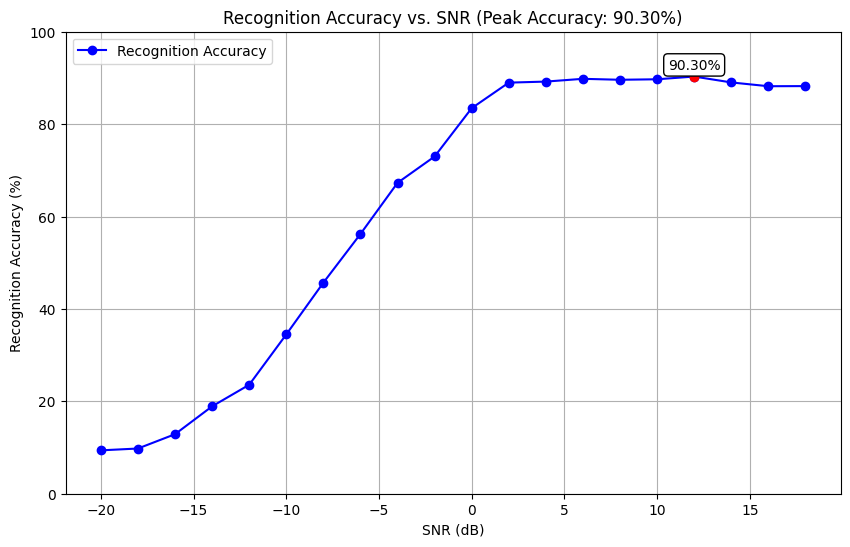

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Evaluate accuracy for each SNR level
unique_snrs = sorted(set(X_test[:, -1]))  # Get unique SNR levels from test set
accuracy_per_snr = []

for snr in unique_snrs:
    # Select samples with the current SNR
    snr_indices = np.where(X_test[:, -1] == snr)
    X_snr = X_test[snr_indices]
    y_snr = y_test[snr_indices]

    # Predict and calculate accuracy
    y_pred = clf.predict(X_snr)
    accuracy = accuracy_score(y_snr, y_pred)
    accuracy_per_snr.append(accuracy * 100)  # Convert to percentage

    print(f"SNR: {snr} dB, Accuracy: {accuracy * 100:.2f}%")

# Find the peak accuracy and its corresponding SNR
peak_accuracy = max(accuracy_per_snr)
peak_snr = unique_snrs[accuracy_per_snr.index(peak_accuracy)]

# Plot Recognition Accuracy vs. SNR
plt.figure(figsize=(10, 6))
plt.plot(unique_snrs, accuracy_per_snr, "b-o", label="Recognition Accuracy")
plt.xlabel("SNR (dB)")
plt.ylabel("Recognition Accuracy (%)")
plt.title(f"Recognition Accuracy vs. SNR (Peak Accuracy: {peak_accuracy:.2f}%)")

# Mark the peak accuracy point
plt.plot(peak_snr, peak_accuracy, "ro")  # Red dot at the peak
plt.text(
    peak_snr,
    peak_accuracy + 1,
    f"{peak_accuracy:.2f}%",
    ha="center",
    va="bottom",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

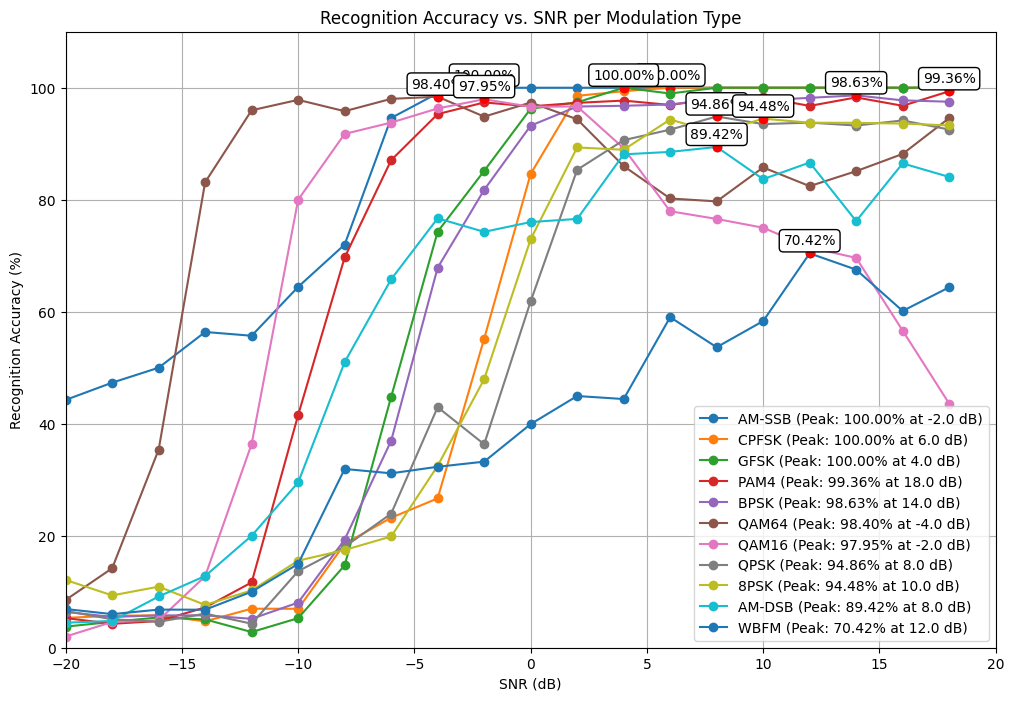

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Get unique modulation types using label encoder classes
unique_modulations = label_encoder.classes_  # This will be the actual class names
unique_snrs = sorted(set(X_test[:, -1]))  # Get unique SNR levels from test set

# Initialize a list to store modulation, accuracy per SNR, and peak accuracy for sorting
modulation_traces = []

# Calculate accuracy for each modulation type and SNR level
for mod_index, mod in enumerate(unique_modulations):
    accuracies = []
    for snr in unique_snrs:
        # Select samples with the current modulation type and SNR
        mod_snr_indices = np.where((y_test == mod_index) & (X_test[:, -1] == snr))
        X_mod_snr = X_test[mod_snr_indices]
        y_mod_snr = y_test[mod_snr_indices]

        # Predict and calculate accuracy
        if (
            len(y_mod_snr) > 0
        ):  # Check if there are samples for this SNR and modulation type
            y_pred = clf.predict(X_mod_snr)
            accuracy = accuracy_score(y_mod_snr, y_pred) * 100  # Convert to percentage
        else:
            accuracy = np.nan  # No data for this SNR-modulation combination

        accuracies.append(accuracy)

    # Calculate peak accuracy for this modulation type
    valid_accuracies = [acc for acc in accuracies if not np.isnan(acc)]
    peak_accuracy = max(valid_accuracies) if valid_accuracies else 0
    peak_snr = (
        unique_snrs[accuracies.index(peak_accuracy)] if peak_accuracy > 0 else None
    )

    # Store the modulation trace data along with peak accuracy for sorting
    modulation_traces.append((mod, accuracies, peak_accuracy, peak_snr))

# Sort the modulation types by peak accuracy in descending order
modulation_traces = sorted(modulation_traces, key=lambda x: x[2], reverse=True)

# Plot Recognition Accuracy vs. SNR for each modulation type
plt.figure(figsize=(12, 8))
for mod, accuracies, peak_accuracy, peak_snr in modulation_traces:
    # Plot the trace for the modulation type
    label = (
        f"{mod} (Peak: {peak_accuracy:.2f}% at {peak_snr} dB)"
        if peak_accuracy > 0
        else mod
    )
    plt.plot(unique_snrs, accuracies, "-o", label=label)

    # Mark the peak accuracy point if it exists
    if peak_accuracy > 0 and peak_snr is not None:
        plt.plot(peak_snr, peak_accuracy, "ro")  # Red dot at the peak
        plt.text(
            peak_snr,
            peak_accuracy + 1,
            f"{peak_accuracy:.2f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
        )

plt.xlabel("SNR (dB)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Recognition Accuracy vs. SNR per Modulation Type")
plt.legend(loc="lower right")
plt.grid(True)
plt.ylim(0, 110)
plt.xlim(-20, 20)
plt.show()

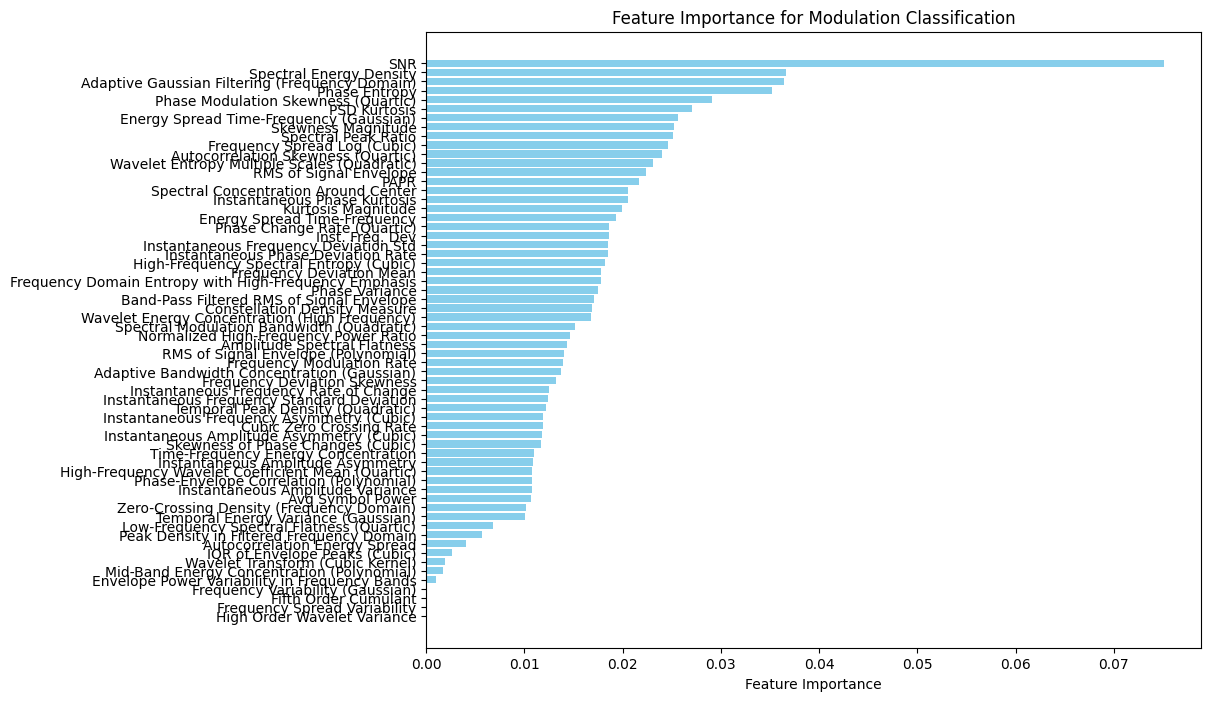

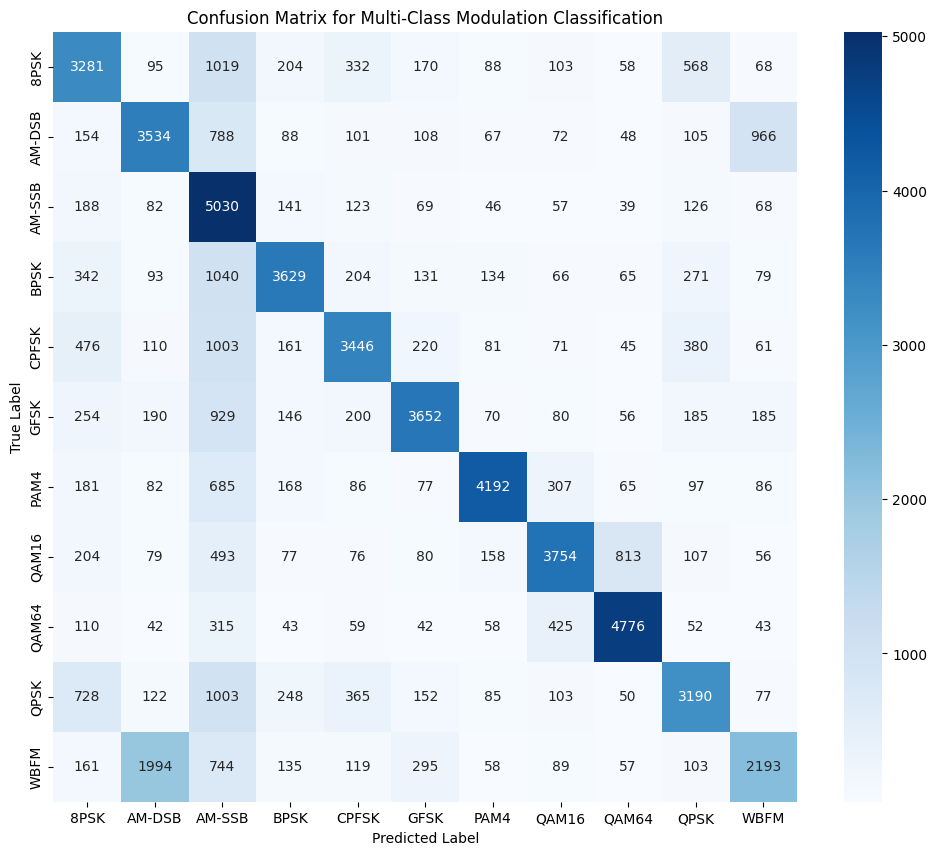

Classification Report for Modulation Types:
              precision    recall  f1-score   support

        8PSK       0.54      0.55      0.54      5986
      AM-DSB       0.55      0.59      0.57      6031
      AM-SSB       0.39      0.84      0.53      5969
        BPSK       0.72      0.60      0.65      6054
       CPFSK       0.67      0.57      0.62      6054
        GFSK       0.73      0.61      0.67      5947
        PAM4       0.83      0.70      0.76      6026
       QAM16       0.73      0.64      0.68      5897
       QAM64       0.79      0.80      0.79      5965
        QPSK       0.62      0.52      0.56      6123
        WBFM       0.56      0.37      0.45      5948

    accuracy                           0.62     66000
   macro avg       0.65      0.62      0.62     66000
weighted avg       0.65      0.62      0.62     66000



In [6]:
# Feature importance for the classifier
feature_names = list(feature_dict.keys())
importances = clf.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot sorted feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Modulation Classification")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Confusion matrix for overall test set
y_pred_test = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Multi-Class Modulation Classification")
plt.show()

# Print Classification Report
print("Classification Report for Modulation Types:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

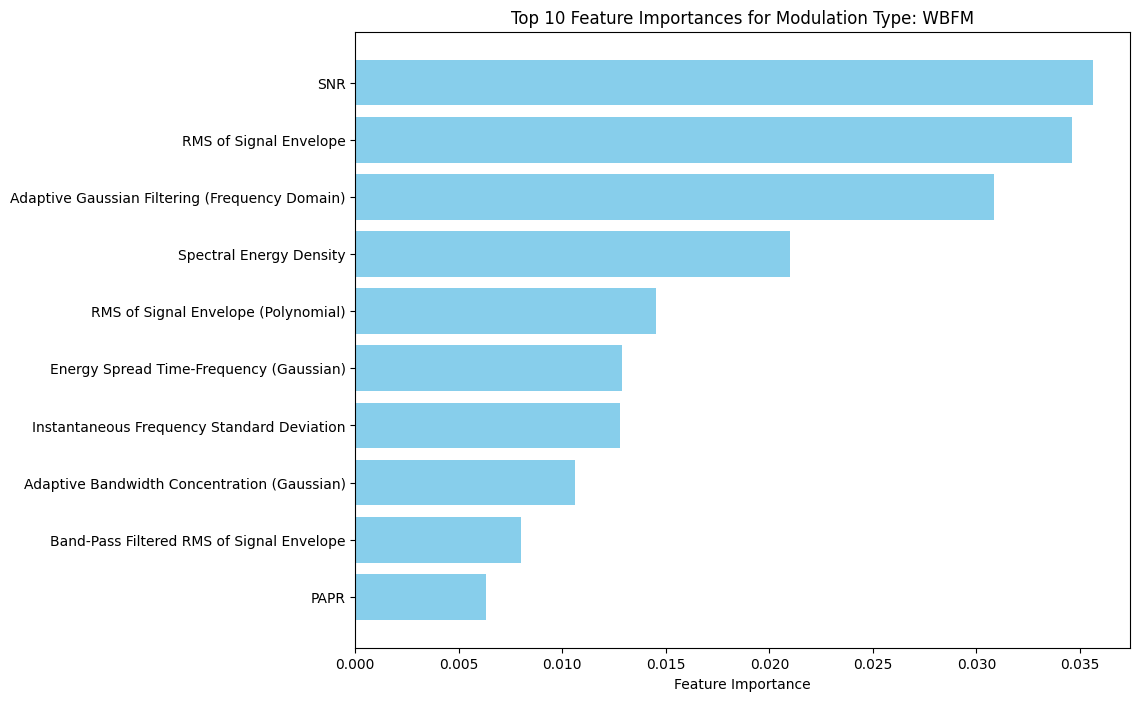

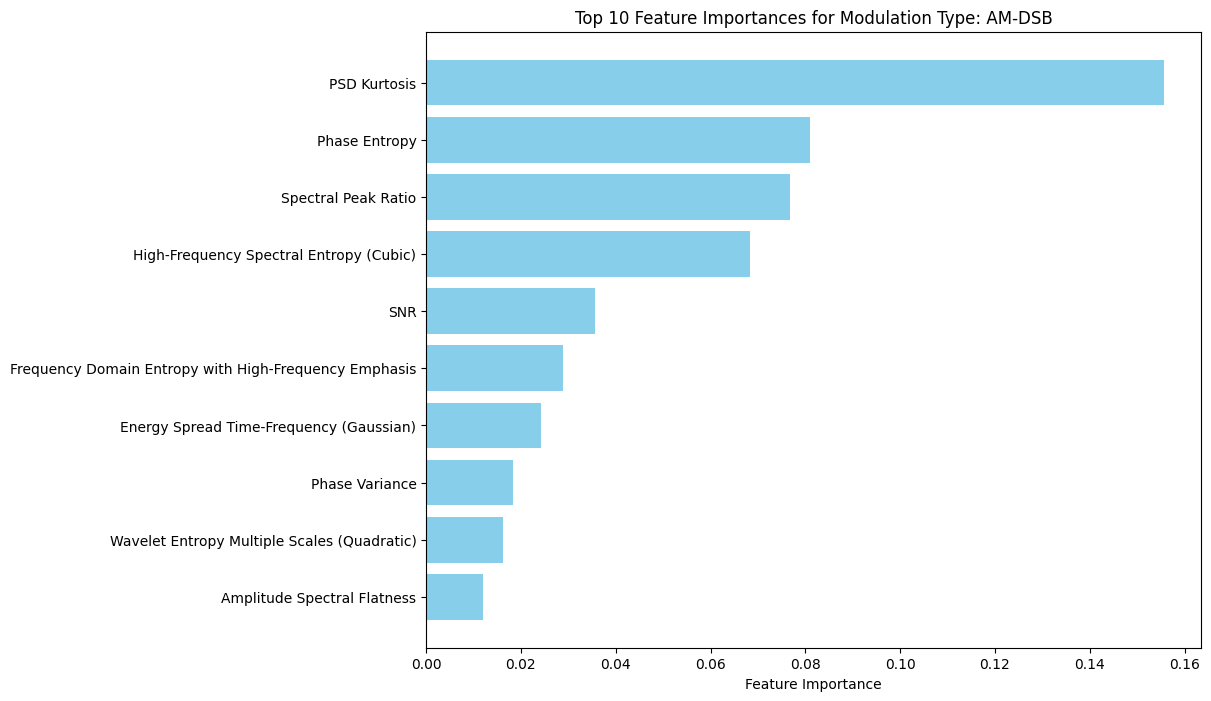

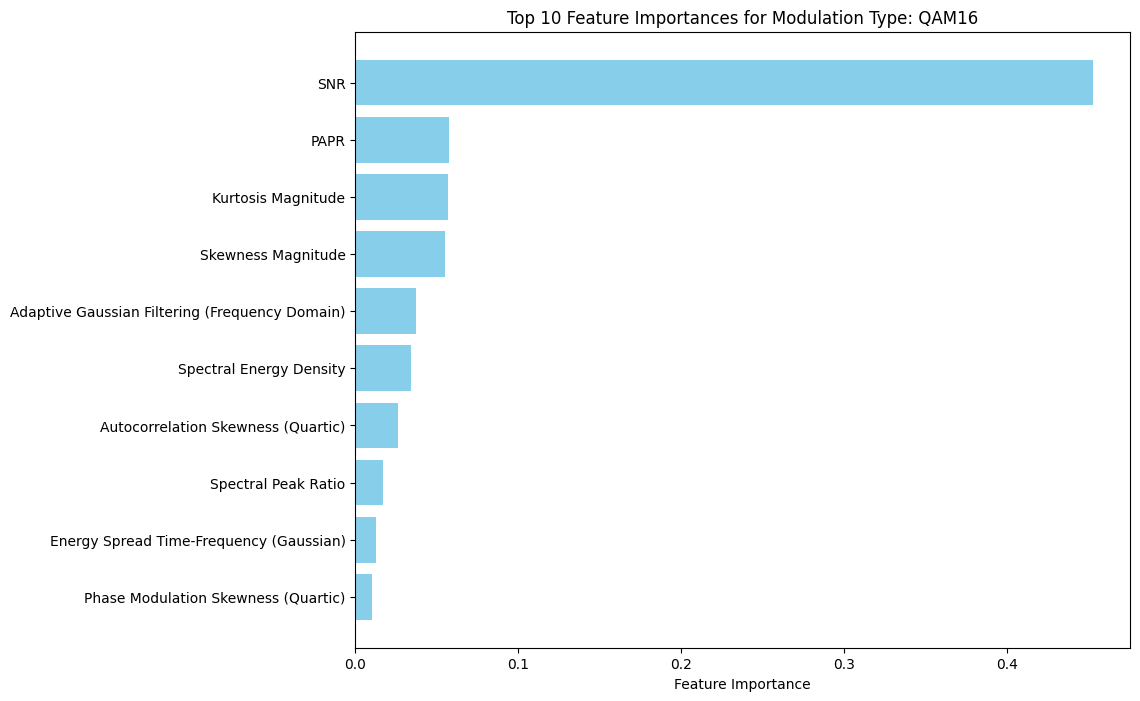

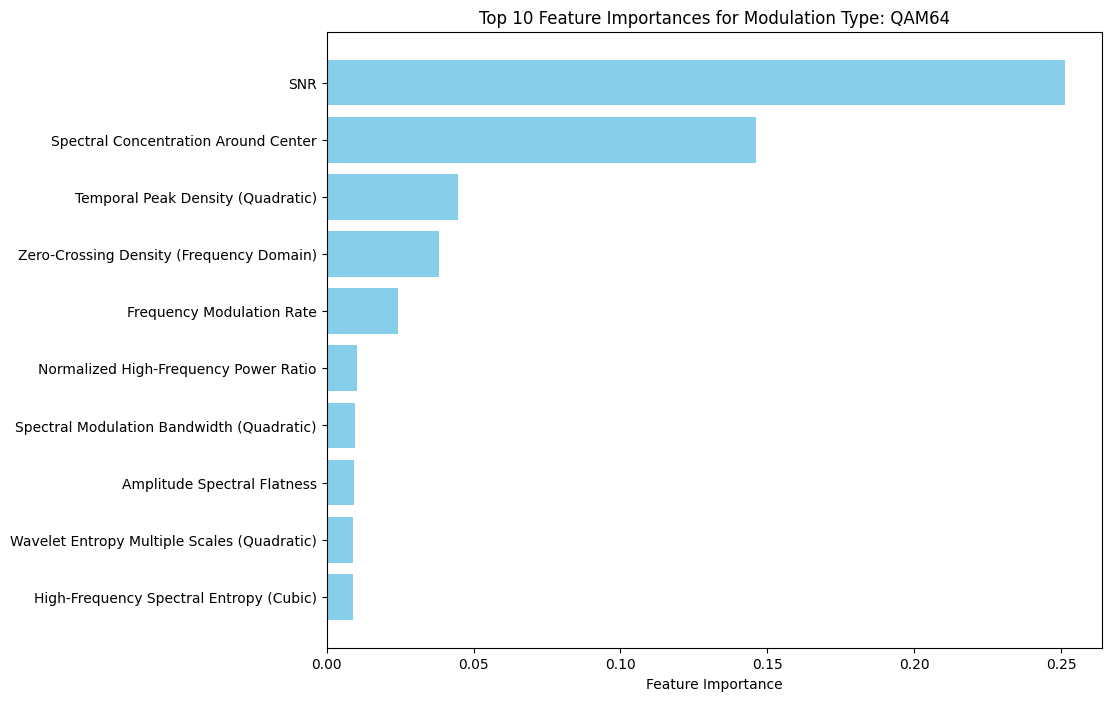

: 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Specify the modulation types of interest
modulation_types_of_interest = ["WBFM", "AM-DSB", "QAM16", "QAM64"]

# Initialize an empty dictionary to hold feature importance per selected modulation type
modulation_importances = {}

# Calculate permutation importance for each selected modulation type
for modulation_type in modulation_types_of_interest:
    # Get the index for the current modulation type from the label encoder
    if modulation_type in label_encoder.classes_:
        i = np.where(label_encoder.classes_ == modulation_type)[0][0]

        # Get indices for the specific modulation type in the test set
        class_indices = np.where(y_test == i)

        # Calculate permutation importance only on this modulation type subset
        result = permutation_importance(
            clf,
            X_test[class_indices],
            y_test[class_indices],
            n_repeats=2,
            random_state=42,
        )

        # Sort the importances
        sorted_indices = np.argsort(result.importances_mean)[::-1]
        sorted_feature_names = [feature_names[j] for j in sorted_indices]
        sorted_importances = result.importances_mean[sorted_indices]

        # Store sorted feature importances for this modulation type
        modulation_importances[modulation_type] = (
            sorted_feature_names,
            sorted_importances,
        )

        # Plot top feature importances for this modulation type
        plt.figure(figsize=(10, 8))
        plt.barh(sorted_feature_names[:10], sorted_importances[:10], color="skyblue")
        plt.xlabel("Feature Importance")
        plt.title(f"Top 10 Feature Importances for Modulation Type: {modulation_type}")
        plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
        plt.show()